In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from util import *
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Initial processing


Loading data

In [2]:
# Loading Train Dataset
train_transaction = pd.read_csv('dataset/train_transaction.csv')
train_identity = pd.read_csv('dataset/train_identity.csv')

Merging transaction and identity files


In [3]:
# Merging the transaction and identity dataset
train_data = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity

gc.collect()
train_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Checking for Duplicate Rows in the training set

In [4]:
duplicate_rows = train_data[train_data.duplicated()]  
print("Duplicate Rows :", duplicate_rows)

Duplicate Rows : Empty DataFrame
Columns: [TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, ...]
Index: []

[0 rows x 434 columns]


Saving the merged train and test dataset into pickle format

In [5]:
train_data.to_pickle('dataset/merged_train.pkl')

del train_data
gc.collect()

0

# Time features

## Initialization

Loading the merged train and test dataset

In [6]:
train_data = pd.read_pickle('dataset/merged_train.pkl')

## Generate time features

Create day column

In [7]:
train_data['day'] = (train_data['TransactionDT']//(3600*24)-1)%7

<AxesSubplot:xlabel='day', ylabel='percentage'>

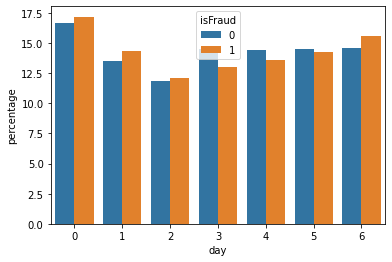

In [8]:
train_day = (train_data.groupby(['isFraud'])['day']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('day'))
sns.barplot(x="day", y="percentage", hue="isFraud", data=train_day)

Create hour column

In [9]:
train_data['hour'] = (train_data['TransactionDT']//(3600))%24

<AxesSubplot:xlabel='hour', ylabel='percentage'>

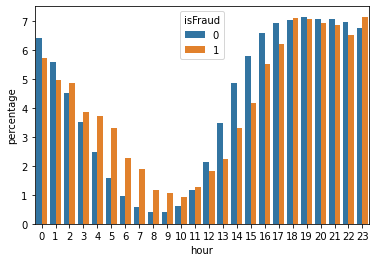

In [10]:
train_hour = (train_data.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))
sns.barplot(x="hour", y="percentage", hue="isFraud", data=train_hour)

In [11]:
train_data.drop(columns = ['TransactionDT'])

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2987001,0,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2987002,0,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2987003,0,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2987004,0,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,23
590536,3577536,0,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,23
590537,3577537,0,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,23
590538,3577538,0,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,23


# Drop insignificant and outlying columns

In [12]:
train_data.drop(columns = ['R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo', 'C12'])

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,day,hour
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,NotFound,32.0,match_status:2,T,F,T,T,mobile,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,23
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,23
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,23
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,23


# Resolving Nan issues

In [13]:
X_train = train_data

In [14]:
columns_def = pd.DataFrame({"NA_count":X_train.isnull().sum().sort_values(ascending=False)})
columns_def["Per"]=columns_def["NA_count"]/len(X_train)
columns_def.head(20)

,NA_count,Per
id_24,585793,0.991962
id_25,585408,0.991310
id_08,585385,0.991271
id_07,585385,0.991271
id_21,585381,0.991264
id_26,585377,0.991257
id_27,585371,0.991247
id_23,585371,0.991247
id_22,585371,0.991247
dist2,552913,0.936284


Remove columns with >= 95% and rows with >= 70% missing values

In [15]:
train = X_train.dropna(axis=1, how='any', thresh=0.05*X_train.shape[0], subset=None, inplace=False)
train = X_train.dropna(axis=0, how='any', thresh=0.3*X_train.shape[1], subset=None, inplace=False)

todrop = X_train.columns.symmetric_difference(train.columns)
print(todrop)

X_train = train

Index([], dtype='object')


In [16]:
print("Train Data Shape : {} \n".format(X_train.shape))

Train Data Shape : (590464, 436) 



In [17]:
X_train.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,0
5,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
7,2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0,0
9,2987009,0,86536,117.000,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Replace missing values in numeric columns with mean of column

In [18]:
column_means = X_train.mean(numeric_only=True)
X_train = X_train.fillna(column_means)
X_train.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.500,W,13926,362.551016,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2987001,0,86401,29.000,W,2755,404.000000,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2987002,0,86469,59.000,W,4663,490.000000,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2987003,0,86499,50.000,W,18132,567.000000,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2987004,0,86506,50.000,H,4497,514.000000,150.0,mastercard,102.0,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,0
5,2987005,0,86510,49.000,W,5937,555.000000,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6,2987006,0,86522,159.000,W,12308,360.000000,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
7,2987007,0,86529,422.500,W,12695,490.000000,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
8,2987008,0,86535,15.000,H,2803,100.000000,150.0,visa,226.0,...,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0,0
9,2987009,0,86536,117.000,W,17399,111.000000,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Replacing missing values in categorical columns with the mode of the column

In [19]:
X_train = X_train.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [20]:
X_train.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.500,W,13926,362.551016,150.0,discover,142.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
1,2987001,0,86401,29.000,W,2755,404.000000,150.0,mastercard,102.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
2,2987002,0,86469,59.000,W,4663,490.000000,150.0,visa,166.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
3,2987003,0,86499,50.000,W,18132,567.000000,150.0,mastercard,117.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
4,2987004,0,86506,50.000,H,4497,514.000000,150.0,mastercard,102.0,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,0
5,2987005,0,86510,49.000,W,5937,555.000000,150.0,visa,226.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
6,2987006,0,86522,159.000,W,12308,360.000000,150.0,visa,166.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
7,2987007,0,86529,422.500,W,12695,490.000000,150.0,visa,226.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
8,2987008,0,86535,15.000,H,2803,100.000000,150.0,visa,226.0,...,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0,0
9,2987009,0,86536,117.000,W,17399,111.000000,150.0,mastercard,224.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0


In [21]:
X_train.to_pickle('dataset/before_labelenc_train.pkl')

# Categorical columns encoding


In [22]:
X_train = pd.read_pickle('dataset/before_labelenc_train.pkl')

## Label encoding

In [15]:
# catf, numf = cat_num_features(X_train)
# categorical_feature_indices = [X_train.columns.get_loc(f) for f in catf]

# Imputing the missing values of Categorical Columns with "missing"
# X_train[catf] = X_train[catf].fillna('missing')

# Label Encoding Categorical Features
# X_train= label_encode(X_train, catf)

## Binary encoding

In [23]:
categorical_columns = X_train.select_dtypes(exclude = np.number).columns.values.tolist()
categorical_columns.append('day')
categorical_columns.append('hour')

In [24]:
import category_encoders as ce
import pandas as pd

encoder= ce.BinaryEncoder(cols=categorical_columns,return_df=True)
data_encoded=encoder.fit_transform(X_train) 
data_encoded

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD_0,ProductCD_1,ProductCD_2,card1,card2,card3,...,DeviceInfo_9,DeviceInfo_10,day_0,day_1,day_2,hour_0,hour_1,hour_2,hour_3,hour_4
0,2987000,0,86400,68.50,0,0,1,13926,362.551016,150.0,...,0,1,0,0,1,0,0,0,0,1
1,2987001,0,86401,29.00,0,0,1,2755,404.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
2,2987002,0,86469,59.00,0,0,1,4663,490.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
3,2987003,0,86499,50.00,0,0,1,18132,567.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
4,2987004,0,86506,50.00,0,1,0,4497,514.000000,150.0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,0,0,1,6550,362.551016,150.0,...,0,1,1,1,1,1,1,0,0,0
590536,3577536,0,15811049,39.50,0,0,1,10444,225.000000,150.0,...,0,1,1,1,1,1,1,0,0,0
590537,3577537,0,15811079,30.95,0,0,1,12037,595.000000,150.0,...,0,1,1,1,1,1,1,0,0,0
590538,3577538,0,15811088,117.00,0,0,1,7826,481.000000,150.0,...,0,1,1,1,1,1,1,0,0,0


In [25]:
data_encoded.shape

(590464, 512)

In [26]:
data_encoded.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD_0,ProductCD_1,ProductCD_2,card1,card2,card3,...,DeviceInfo_9,DeviceInfo_10,day_0,day_1,day_2,hour_0,hour_1,hour_2,hour_3,hour_4
0,2987000,0,86400,68.5,0,0,1,13926,362.551016,150.0,...,0,1,0,0,1,0,0,0,0,1
1,2987001,0,86401,29.0,0,0,1,2755,404.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
2,2987002,0,86469,59.0,0,0,1,4663,490.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
3,2987003,0,86499,50.0,0,0,1,18132,567.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
4,2987004,0,86506,50.0,0,1,0,4497,514.000000,150.0,...,1,0,0,0,1,0,0,0,0,1


In [27]:
X_train = data_encoded

Saving the output datasets

In [28]:
X_train.to_pickle('dataset/after_labelenc_train.pkl')

# Dimensionality reduction

In [8]:
bf_enc = pd.read_pickle('dataset/before_labelenc_train.pkl')

In [9]:
numerical_columns = bf_enc.select_dtypes(include = np.number).columns
numerical_columns = numerical_columns.drop(['isFraud', 'TransactionID', 'day', 'hour'])
numerical_columns = numerical_columns.values.tolist()

## Principal Component Analysis (PCA)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

# y = X_train['isFraud']
# X = X_train.drop(['isFraud', 'TransactionID'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34, stratify=y)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)


In [ ]:
# from sklearn.decomposition import PCA
 
# columns = ['ft_%i' % i for i in range(400)]

# pca = PCA(n_components = 400)

# train = pd.DataFrame(pca.fit_transform(X_train), columns=columns)

# test = pd.DataFrame(pca.transform(X_test), columns=columns)
 
# explained_variance = pca.explained_variance_ratio_

## Normalization

In [10]:
X_train = pd.read_pickle('dataset/after_labelenc_train.pkl')

In [11]:
X_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD_0,ProductCD_1,ProductCD_2,card1,card2,card3,...,DeviceInfo_9,DeviceInfo_10,day_0,day_1,day_2,hour_0,hour_1,hour_2,hour_3,hour_4
0,2987000,0,86400,68.5,0,0,1,13926,362.551016,150.0,...,0,1,0,0,1,0,0,0,0,1
1,2987001,0,86401,29.0,0,0,1,2755,404.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
2,2987002,0,86469,59.0,0,0,1,4663,490.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
3,2987003,0,86499,50.0,0,0,1,18132,567.000000,150.0,...,0,1,0,0,1,0,0,0,0,1
4,2987004,0,86506,50.0,0,1,0,4497,514.000000,150.0,...,1,0,0,0,1,0,0,0,0,1


In [12]:
X_train.shape

(590464, 512)

In [13]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# define min max scaler
scaler = MinMaxScaler()
# transform data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# X_train[numerical_columns]= preprocessing.normalize(X_train[numerical_columns])

y = X_train['isFraud']
X = X_train.drop(['isFraud', 'TransactionID'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34, stratify=y)


In [14]:
X_train.head()

,TransactionDT,TransactionAmt,ProductCD_0,ProductCD_1,ProductCD_2,card1,card2,card3,card4_0,card4_1,...,DeviceInfo_9,DeviceInfo_10,day_0,day_1,day_2,hour_0,hour_1,hour_2,hour_3,hour_4
532736,0.887745,0.007069,0,0,1,0.336744,0.910,0.381679,0,1,...,0,1,0,0,1,0,1,1,1,0
7456,0.009737,0.000775,0,0,1,0.397735,0.188,0.381679,0,1,...,0,1,0,1,0,1,0,0,1,1
580606,0.978746,0.000369,0,1,1,0.737641,0.550,0.648855,0,1,...,0,0,1,0,0,0,0,1,0,0
451764,0.728533,0.001807,0,0,1,0.756553,0.580,0.381679,0,1,...,0,1,1,1,1,0,1,1,1,1
512923,0.849010,0.003372,0,0,1,0.661129,0.780,0.381679,0,1,...,0,1,0,0,1,0,1,1,0,1


In [15]:
X_train.shape

(413324, 510)

# K-best features

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

select = SelectKBest(score_func=chi2, k=300)
z = select.fit_transform(X_train, y_train)

z.shape

(413324, 300)

In [17]:
filter = select.get_support()
features = np.array(X_train.columns.values.tolist())


In [18]:
chosen_columns = features[filter].tolist()

In [19]:
train = X_train[chosen_columns]
test = X_test[chosen_columns]

In [20]:
train.shape

(413324, 300)

# Balancing data

In [21]:
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.041)
steps = [('u', under), ('o',over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_res, y_train_res = pipeline.fit_resample(train, y_train)

y_train_res.value_counts()
    

0    352682
1    176341
Name: isFraud, dtype: int64

In [22]:
X_train_res.to_pickle('dataset/X_train.pkl')
y_train_res.to_pickle('dataset/y_train.pkl')

test.to_pickle('dataset/X_test.pkl')
y_test.to_pickle('dataset/y_test.pkl')